In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

### Task 1.1
# Load the training data from the source CSV
Load the dataset from the provided CSV into a numpy array and then seperate it out into the target values, training data and the ship names.

In [2]:
with open("containers.csv", "r") as srcF:
    src = np.array(list(csv.reader(srcF, delimiter=",")))

data = {
    "target": np.array(src[:, 7], int),
    "data": np.array(np.concatenate((src[:, 2:7], src[:, 8:]), axis=1), float),
    "names": src[:, 1]
}

# Prepare Data
## Normalise data and perform PCA
  - Calculate the index position for each target value
  - Normalise the  source data using sklearn.preprocessing.normalize
  - Perform 2d PCA using sklearn.decomposition.PCA and PCA.fit_transform

[]

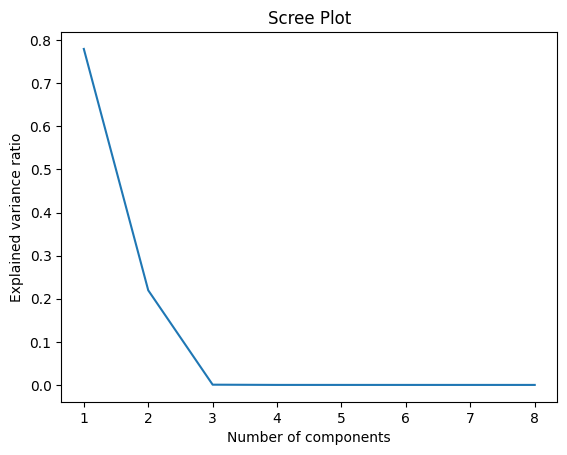

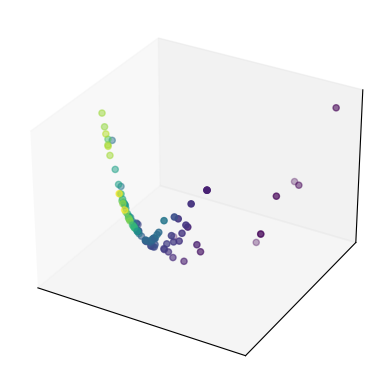

In [3]:
from sklearn import decomposition, preprocessing

data["normalisedData"] = preprocessing.normalize(data["data"])

pca = decomposition.PCA()
pca.fit(data["normalisedData"])
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Scree Plot')

PCA = decomposition.PCA(n_components=3) # "elbow" of the scree plot
projection = PCA.fit_transform(data["normalisedData"])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=preprocessing.normalize([data["target"]]), cmap="viridis")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

### Task 1.3 (1.2 is below)
# Regression
## The data will now be used to evaluate three regression models
  - A Random Forest using sklearn.ensemble.RandomForestRegressor
  - A Neural Network using sklearn.neural_network.MLPRegressor
  - A Support Vector Machine using sklearn.svm.SVR

Each model will first be evaluated using cross validation to find the mean squared error rate. This process will be repeated 30 times and then the outcome will be displayed on a box plot.
Next, the model will be trained with the full set of data and the model will be used to predict the capacity of each ship. the top ten ships ordered by the predicted capacity will then be displayed in a table along with their actual capacities.

In [4]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.base import clone

def predictContainers(data, target, names, top_n, model):
    """
    Take a regressor and predict the top 10 highest capacity container ships.
    :param data: The full data set for the container ships
    :param target: The target data for all the container ships
    :param names: The names of all the container ships
    :param top_n: The number of ships to return going from predicted capacity down
    :param model: The regressor to use
    :return: A numpy array of top (top_n) highest predicted capacity container ships, their predicted capacities and their actual capacities
    """
    predictions = np.array(model.predict(data), int)
    order = np.argsort(predictions)

    out = np.array([names[order[-top_n:]], predictions[order[-top_n:]], target[order[-top_n:]]])

    plt.figure()
    fig, ax = plt.subplots()
    figData = np.rot90(out, 1) # matplotlib wants each ship to be a column not a row
    fig.patch.set_visible(False)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=figData, loc='center', colLabels=("Container Ship", "Predicted Capacity", "Actual Capacity"))
    table.set_fontsize(30)
    table.scale(3, 3)
    return out

def evaluateModel(repeats, model_in):
    """
    Takes a model, performs (repeats) rounds of cross validation, starting with a fresh model each iteration.
    :param repeats: The number of times to repeat cross validation
    :param model_in: The model to evaluate
    :return: the training accuracy and the test accuracy for each round of cross validation
    """
    trainAcc = []
    testAcc = []
    scorer = make_scorer(mean_squared_error)

    for X in range(repeats):
        model = clone(model_in)
        X_train, X_test, y_train, y_test = train_test_split(projection, data["target"], train_size=0.75)
        model.fit(X_train, y_train)

        trainAcc.append(cross_val_score(model, X_train, y_train, scoring=scorer))
        testAcc.append(scorer(model, X_test, y_test))

    plt.figure()
    trainAccNp = np.array(trainAcc)
    plt.boxplot([trainAccNp.flatten(), testAcc], showfliers=False)
    plt.xlabel("(1) train, (2) test")
    plt.ylabel("Mean Squared Error (the lower the better)")
    return trainAcc, testAcc

### Task 1.2
## Random Forest

([array([ 6993078.05553334,  3657435.99558   , 24260791.21604667,
          7388846.37124667,  4327506.67944   ]),
  array([8083853.75538666, 3819006.21320667, 7932354.58964   ,
         6604894.41534667, 9848629.30494667]),
  array([ 7501626.41486   ,  4644800.92254   , 12990795.44450667,
          4439536.93129333,  5838810.76708667]),
  array([ 7813443.19213334,  9469509.67859333,  1810333.76597333,
          9598919.74999333, 14793257.12556667]),
  array([13385737.11833333,  9338651.67088   ,  5084096.58757333,
          9408027.71314   ,  3139946.30072667]),
  array([10591467.50474   ,  4192057.62736667,  7273052.29340667,
         15157121.43687334,  9092025.49692667]),
  array([ 9449071.16688667,  2859592.98854667,  9814953.74582   ,
          4608255.55964667, 16941672.87644   ]),
  array([ 5978910.25294   ,  9728395.75754   ,  2916396.33684   ,
          6025966.43106667, 10001134.99498667]),
  array([4954282.09186, 5353715.0804 , 4292984.68906, 5687759.20812,
         5601845

<Figure size 640x480 with 0 Axes>

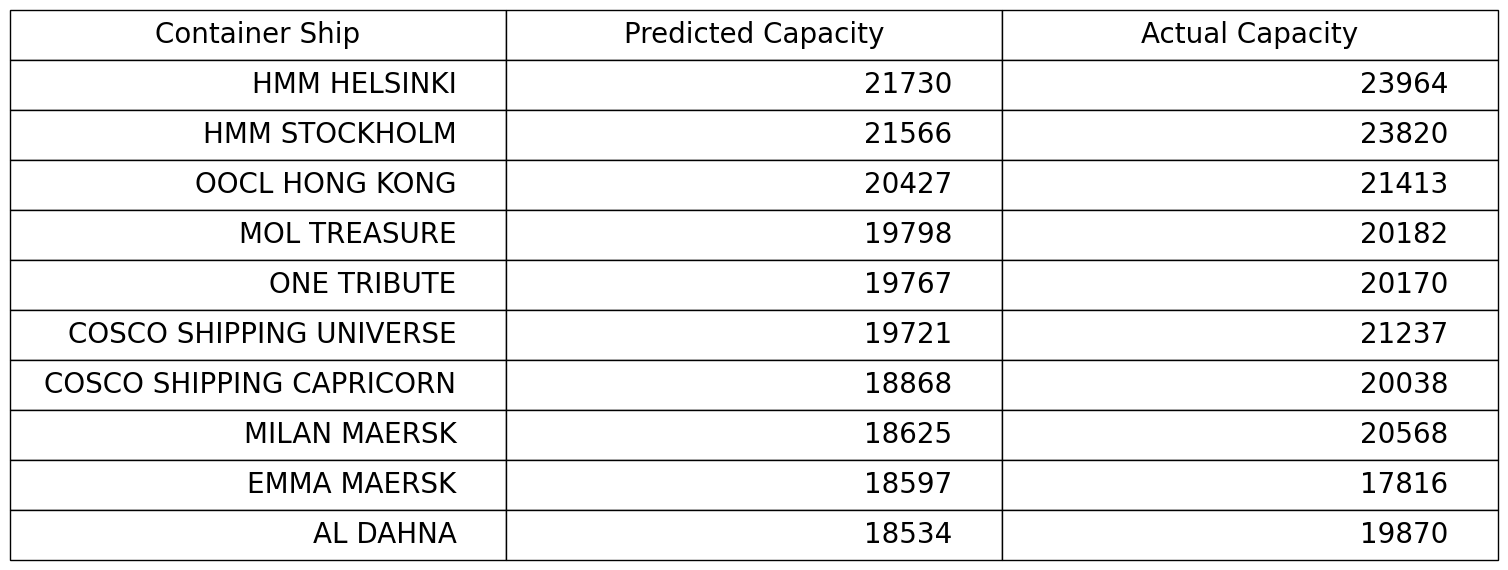

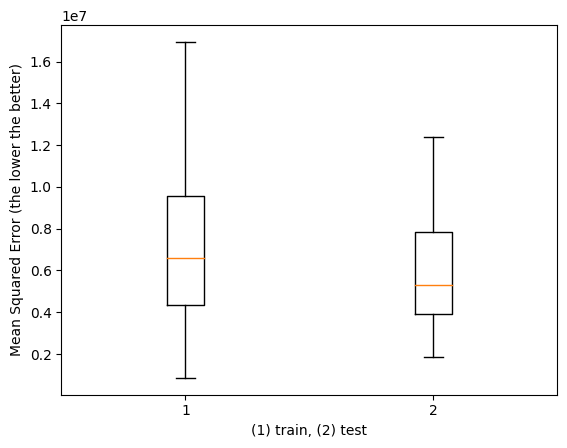

In [5]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

rfr.fit(projection, data["target"])
predictContainers(projection, data["target"], data["names"], 10, rfr)

evaluateModel(30, rfr)

## Neural Network

([array([936657.51066013, 599665.89278803, 734267.97601339, 396292.74383514,
         277565.51999445]),
  array([486406.1338427 , 108235.21553245, 888214.40979273, 289420.37848479,
         744182.73559293]),
  array([  381983.93433971,   496295.56886052, 15283092.36136024,
           347739.74757782,   270358.42431262]),
  array([713014.15719003, 163596.75218369, 328527.37327423, 639156.3309389 ,
         410730.18786281]),
  array([ 258306.80858221, 1746843.10181518, 1068986.70272087,
          283657.68637966,  428486.49889845]),
  array([214399.5670267 , 262066.69564144, 330323.29204868, 658029.43093581,
         596699.92498768]),
  array([265438.94290327, 511797.28499234, 298459.13045613, 247187.20565461,
         499923.21707354]),
  array([1424740.7970158 ,  624663.72064582,  512869.02417086,
         2827131.42338238,  836082.80116012]),
  array([ 948247.11946572,  113706.26033648,  826881.32792021,
         1100812.78746372, 2497992.89540672]),
  array([ 296838.68166064,  17

<Figure size 640x480 with 0 Axes>

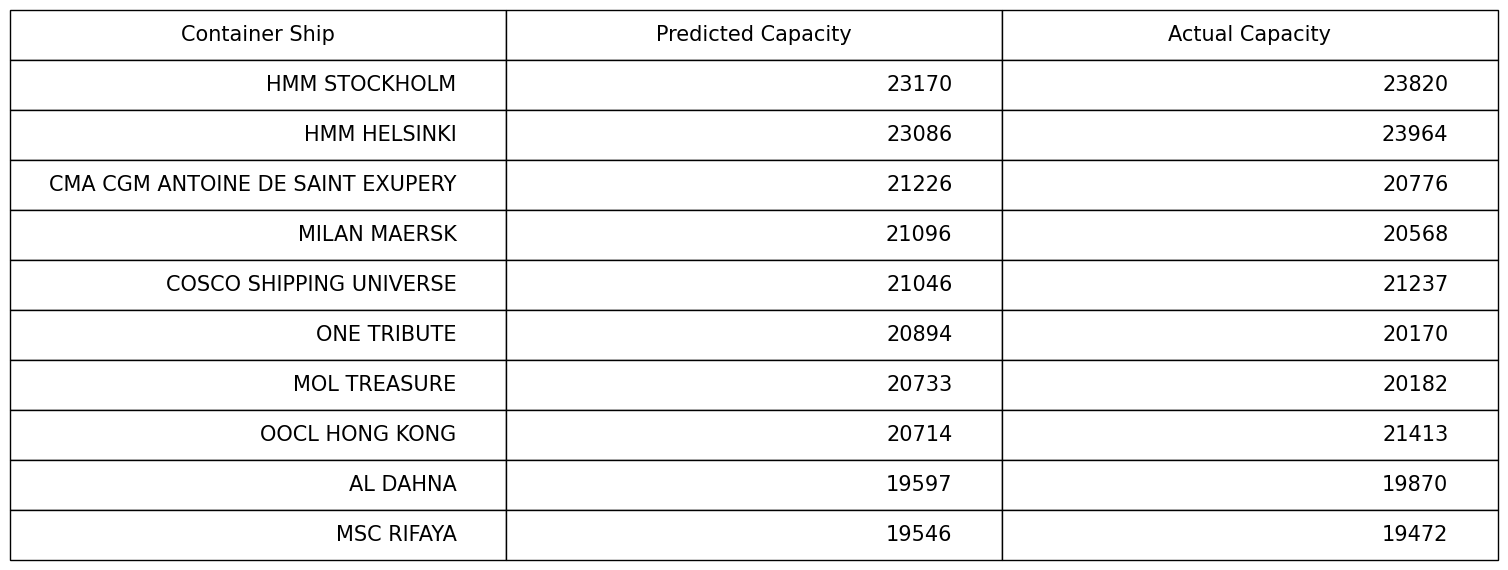

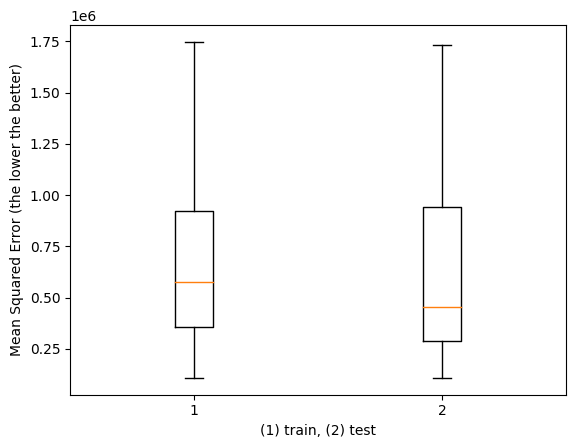

In [6]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor(early_stopping=True, max_iter=10000, solver='lbfgs')

mlpr.fit(projection, data["target"])
predictContainers(projection, data["target"], data["names"], 10, mlpr)

evaluateModel(30, mlpr)

## Support Vector Machine

([array([46492316.57682572, 49428374.79761007, 34746984.18253258,
         46195894.51303376, 19460653.51670535]),
  array([44413552.73027217, 14783367.66892713, 46696408.42320428,
         59808098.58396848, 45213487.69990487]),
  array([32167777.80918531, 36126217.80635982, 44922202.04298834,
         62249386.74955249, 37303428.60564663]),
  array([25602288.77566483, 60639093.14266912, 34057822.45084839,
         39826706.62427907, 39621817.65866374]),
  array([45622032.38991515, 24488478.78188811, 17808592.98988964,
         50450375.67069088, 65153243.70305359]),
  array([34529014.55297751, 33574962.92102232, 39530797.90480039,
         30411376.8711227 , 52732371.23931377]),
  array([25787795.68678568, 64589881.1105849 , 23016897.67512007,
         44304838.88893822, 31372348.94977785]),
  array([50851833.51448343, 39463874.01632973, 41139161.93304665,
         26357993.51522068, 22271778.49708165]),
  array([21934612.06005478, 47416369.94869952, 27539628.02169644,
         47358

<Figure size 640x480 with 0 Axes>

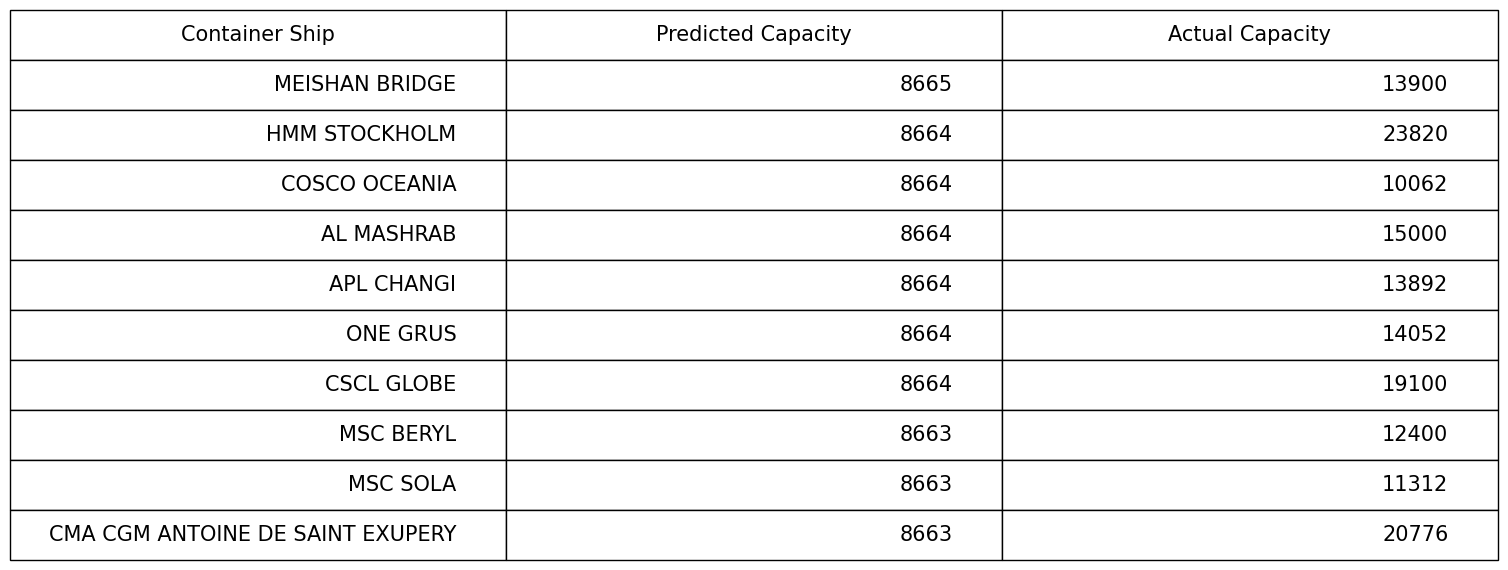

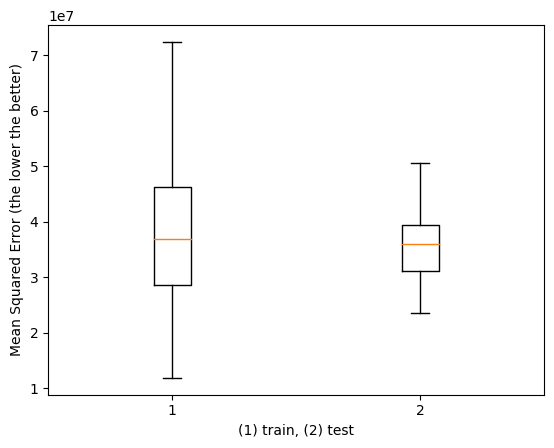

In [7]:
from sklearn.svm import SVR
svr = SVR()

svr.fit(projection, data["target"])
predictContainers(projection, data["target"], data["names"], 10, svr)

evaluateModel(30, svr)